Found 4432 images belonging to 4 classes.
Found 572 images belonging to 4 classes.
Found 144 images belonging to 4 classes.


17225924/17225924 [==============================] - 15s 1us/step
Epoch 1/50


139/139 [==============================] - 429s 3s/step - loss: 0.6678 - accuracy: 0.7344 - val_loss: 0.3570 - val_accuracy: 0.8619 - lr: 0.0010
Epoch 2/50
139/139 [==============================] - 381s 3s/step - loss: 0.3526 - accuracy: 0.8639 - val_loss: 0.2697 - val_accuracy: 0.9073 - lr: 0.0010
Epoch 3/50
139/139 [==============================] - 369s 3s/step - loss: 0.2849 - accuracy: 0.8894 - val_loss: 0.2552 - val_accuracy: 0.8951 - lr: 0.0010
Epoch 4/50
139/139 [==============================] - 744s 5s/step - loss: 0.2388 - accuracy: 0.9138 - val_loss: 0.2726 - val_accuracy: 0.8986 - lr: 0.0010
Epoch 5/50
139/139 [==============================] - 886s 6s/step - loss: 0.2061 - accuracy: 0.9235 - val_loss: 0.2115 - val_accuracy: 0.9248 - lr: 0.0010
Epoch 6/50
139/139 [======

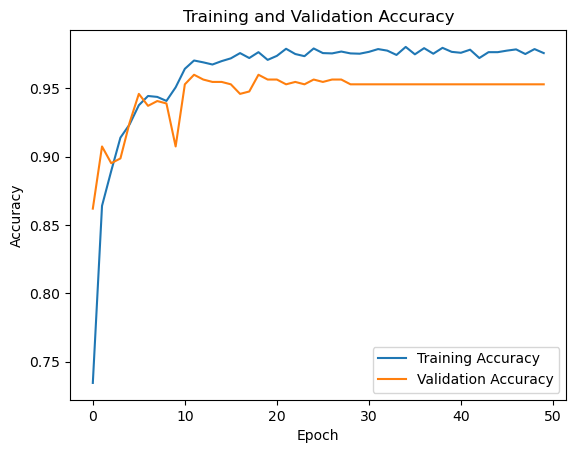

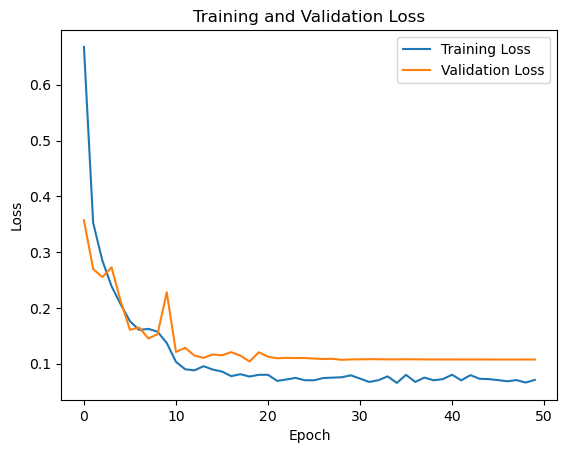

5/5 [==============================] - 7s 995ms/step - loss: 0.1332 - accuracy: 0.9514

Test Loss: 0.1332, Test Accuracy: 0.9514
5/5 [==============================] - 8s 939ms/step


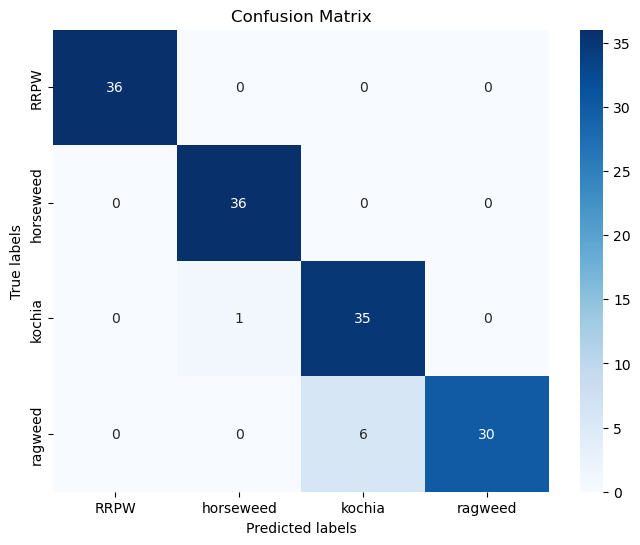

              precision    recall  f1-score   support

        RRPW       1.00      1.00      1.00        36
   horseweed       0.97      1.00      0.99        36
      kochia       0.85      0.97      0.91        36
     ragweed       1.00      0.83      0.91        36

    accuracy                           0.95       144
   macro avg       0.96      0.95      0.95       144
weighted avg       0.96      0.95      0.95       144


Class: RRPW
True Positives: 36, True Negatives: 108, False Positives: 0, False Negatives: 0

Class: horseweed
True Positives: 36, True Negatives: 107, False Positives: 1, False Negatives: 0

Class: kochia
True Positives: 35, True Negatives: 102, False Positives: 6, False Negatives: 1

Class: ragweed
True Positives: 30, True Negatives: 108, False Positives: 0, False Negatives: 6


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.mobilenet import preprocess_input

# Set the paths to your training, validation, and test datasets
train_data_dir = r"C:\Users\DELL\Desktop\Weed Aug\Training"
val_data_dir = r"C:\Users\DELL\Desktop\Weed Aug\Validation"
test_data_dir = r"C:\Users\DELL\Desktop\Weed Aug\Testing"

# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input  # MobileNet-specific preprocessing
)

# Data Augmentation for Validation (only normalization)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Data Augmentation for Testing (only normalization)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create data generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Assuming 24 classes, adjust as needed
num_classes = 4

# Load pre-trained MobileNet without the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze early layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a model with custom classification layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Class Weights Calculation
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)

# Learning Rate Schedule
def lr_schedule(epoch):
    return 1e-3 * (0.1 ** (epoch // 10))

lr_scheduler = LearningRateScheduler(lr_schedule)

# Model Training
num_epochs = 50  # Adjust as needed

history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    class_weight=dict(enumerate(class_weights)),
    callbacks=[lr_scheduler]
)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Model Evaluation on Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict probabilities for test set
Y_pred = model.predict(test_generator)
# Convert probabilities to class labels
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

# Calculate TP, TN, FP, FN
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

for i in range(len(class_names)):
    print(f"\nClass: {class_names[i]}")
    print(f"True Positives: {TP[i]}, True Negatives: {TN[i]}, False Positives: {FP[i]}, False Negatives: {FN[i]}")


In [16]:
# Iterate over each class
for class_index in range(num_classes):
    # Calculate True Positives, True Negatives, False Positives, and False Negatives for the current class
    TP = conf_matrix[class_index, class_index]
    TN = np.sum(np.delete(np.delete(conf_matrix, class_index, axis=0), class_index, axis=1))
    FP = np.sum(conf_matrix[:, class_index]) - TP
    FN = np.sum(conf_matrix[class_index, :]) - TP

    # Calculate class-wise accuracy
    class_accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Print class-wise accuracy
    print(f"Class: {class_names[class_index]}, Accuracy: {class_accuracy:.4f}")


Class: RRPW, Accuracy: 1.0000
Class: horseweed, Accuracy: 0.9931
Class: kochia, Accuracy: 0.9514
Class: ragweed, Accuracy: 0.9583


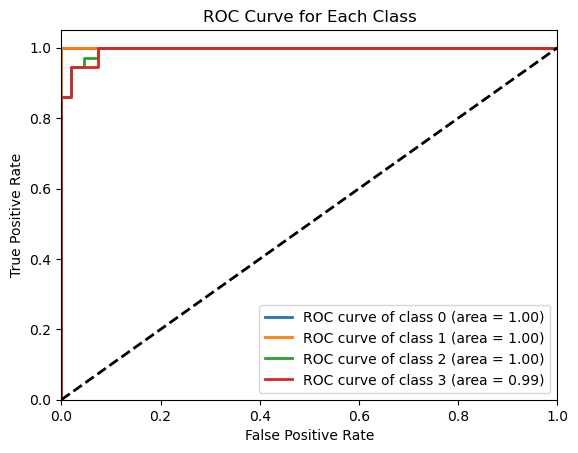

In [6]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_true_binary = label_binarize(y_true, classes=np.unique(y_true))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()


In [7]:
from sklearn.metrics import roc_auc_score

# Compute AUC for each class
auc_scores = dict()
for i in range(num_classes):
    auc_scores[class_names[i]] = roc_auc_score(y_true_binary[:, i], Y_pred[:, i])

# Print AUC for each class
print("\nAUC for Each Class:")
for class_name, auc_score in auc_scores.items():
    print(f"{class_name}: {auc_score:.4f}")



AUC for Each Class:
RRPW: 1.0000
horseweed: 1.0000
kochia: 0.9951
ragweed: 0.9943


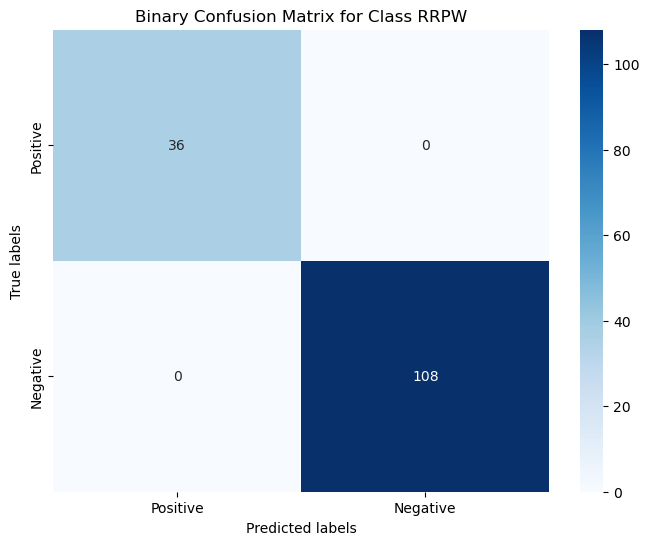

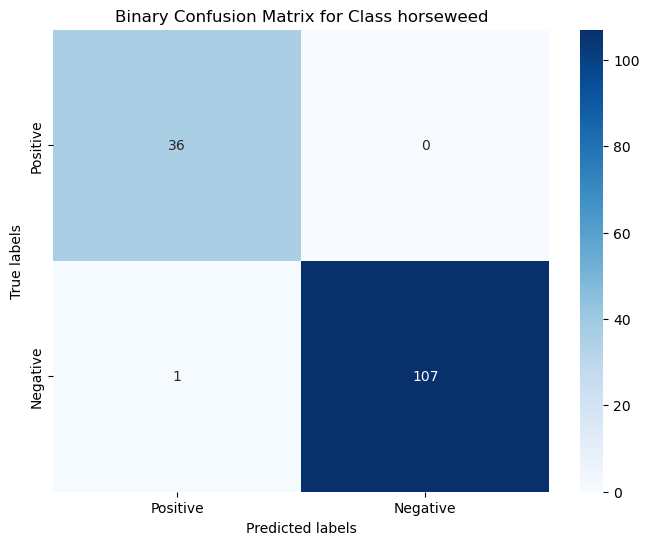

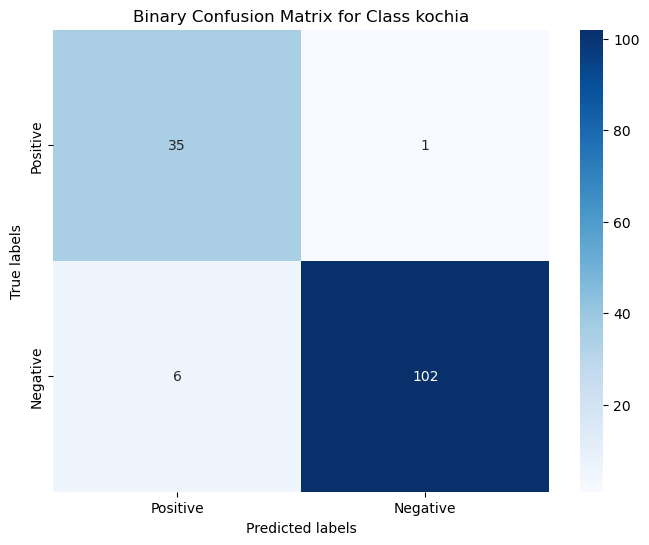

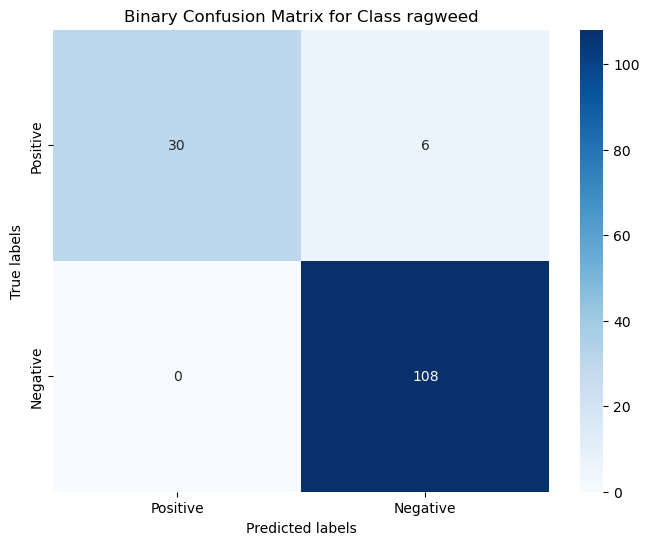

In [10]:
# Iterate over each class
for class_index in range(num_classes):
    # Convert true labels and predicted labels to binary for the current class
    y_true_binary = (y_true == class_index)
    y_pred_binary = (y_pred == class_index)

    # Generate confusion matrix for the current class
    conf_matrix_binary = confusion_matrix(y_true_binary, y_pred_binary)

    # Reorder the confusion matrix according to the correct order
    conf_matrix_binary = conf_matrix_binary[::-1, ::-1]  # Reverse both rows and columns

    # Plot binary confusion matrix for the current class using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_binary, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Binary Confusion Matrix for Class {class_names[class_index]}')
    plt.show()


In [11]:
from sklearn.metrics import classification_report

# Iterate over each class
for class_index in range(num_classes):
    # Convert true labels and predicted labels to binary for the current class
    y_true_binary = (y_true == class_index)
    y_pred_binary = (y_pred == class_index)

    # Reorder the confusion matrix according to the correct order
    conf_matrix_binary = confusion_matrix(y_true_binary, y_pred_binary)[::-1, ::-1]

    # Generate classification report for the current class
    class_report = classification_report(y_true_binary, y_pred_binary, target_names=['Negative', 'Positive'])

    # Print classification report for the current class
    print(f"Classification Report for Class {class_names[class_index]}:\n")
    print(class_report)
    print("\n")


Classification Report for Class RRPW:

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       108
    Positive       1.00      1.00      1.00        36

    accuracy                           1.00       144
   macro avg       1.00      1.00      1.00       144
weighted avg       1.00      1.00      1.00       144



Classification Report for Class horseweed:

              precision    recall  f1-score   support

    Negative       1.00      0.99      1.00       108
    Positive       0.97      1.00      0.99        36

    accuracy                           0.99       144
   macro avg       0.99      1.00      0.99       144
weighted avg       0.99      0.99      0.99       144



Classification Report for Class kochia:

              precision    recall  f1-score   support

    Negative       0.99      0.94      0.97       108
    Positive       0.85      0.97      0.91        36

    accuracy                           0.95       144


In [12]:
from sklearn.metrics import classification_report

# Generate classification report for the entire test set
report = classification_report(y_true, y_pred, target_names=class_names)

# Print classification report
print("Classification Report for the Entire Test Set:\n")
print(report)


Classification Report for the Entire Test Set:

              precision    recall  f1-score   support

        RRPW       1.00      1.00      1.00        36
   horseweed       0.97      1.00      0.99        36
      kochia       0.85      0.97      0.91        36
     ragweed       1.00      0.83      0.91        36

    accuracy                           0.95       144
   macro avg       0.96      0.95      0.95       144
weighted avg       0.96      0.95      0.95       144

